## Multi Label Classification of satellite photos

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.image import imread
from pandas import read_csv
from os import listdir
from keras.preprocessing.image import load_img
from keras import backend
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers.legacy import SGD

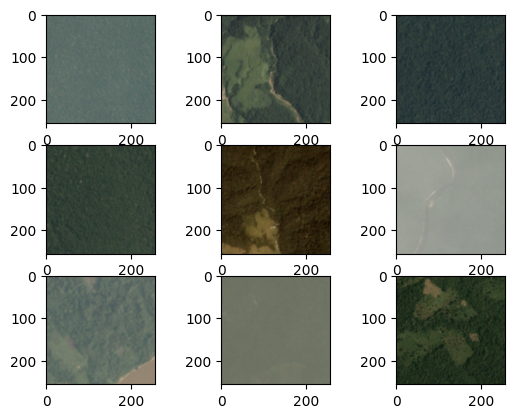

In [2]:
folder = "train-jpg/"
# Plotting first 9 images
for i in range(9):
    plt.subplot(330+1+i)
    # File name
    filename = folder + 'train_' + str(i) + '.jpg'
    # image pixels
    image = imread(filename)
    # Plotting the image
    plt.imshow(image)
plt.show()

In [3]:
def create_mapping(mapping_csv):
    # Storing all the tags in list sets
    labels = set()
    for i in range(len(mapping_csv)):
        tags = mapping_csv['tags'][i].split(' ')
        labels.update(tags)
    labels = list(labels)
    labels.sort()

    # Creating a dictionary to map the labels 
    labels_map = {labels[i]:i for i in range(len(labels))} 
    return labels_map

In [5]:
filename = 'train_classes.csv'
mapping_csv = read_csv(filename)
mapping= create_mapping(mapping_csv)
print(len(mapping))
print(mapping)

17
{'agriculture': 0, 'artisinal_mine': 1, 'bare_ground': 2, 'blooming': 3, 'blow_down': 4, 'clear': 5, 'cloudy': 6, 'conventional_mine': 7, 'cultivation': 8, 'habitation': 9, 'haze': 10, 'partly_cloudy': 11, 'primary': 12, 'road': 13, 'selective_logging': 14, 'slash_burn': 15, 'water': 16}


In [6]:
# Creating file mapping for all the jpeg in training folder
def create_file_mapping(mapping_csv):
    mapping = dict()
    for i in range(len(mapping_csv)):
        name, tags = mapping_csv['image_name'][i], mapping_csv['tags'][i]
        mapping[name] = tags.split(' ')
    return mapping

In [7]:
def one_hot_encoding(tags, mapping):
    # Create empty vector
    encoding = np.zeros(len(mapping), dtype='uint8')
    # Marking 1 for each tag in the vector 
    for tag in tags:
        encoding[mapping[tag]] = 1
    return encoding

In [8]:
def load_dataset(path, file_mapping, tag_mapping):
    photos, targets = list(), list()
    # Enumerate files in the directory
    for filename in listdir(folder):
        # Loading images
        photo = load_img (path + filename, target_size=(128,128))
        # coverting the images into an array
        photo = img_to_array(photo, dtype='uint8')
        # Getting tags
        tags = file_mapping[filename[:-4]]
        # OneHot encoding the tags
        target = one_hot_encoding(tags, tag_mapping)
        # Storing the data
        photos.append(photo)
        targets.append(target)
    X = np.asarray(photos, dtype='uint8')
    y = np.asarray(targets, dtype='uint8')
    return X, y

In [9]:
# Loading the mapping file
filename = 'train_classes.csv'
mapping_csv = read_csv(filename)
# Calling tag mapping function 
tag_mapping = create_mapping(mapping_csv)
# Calling file mapping function
file_mapping = create_file_mapping(mapping_csv)
# Loading the jpeg files
folder = 'train-jpg/'
X,y = load_dataset(folder, file_mapping, tag_mapping)
print(X.shape)
print(y.shape)


(40479, 128, 128, 3)
(40479, 17)


### Model Evaluation Measure
Since this problem has multiple class lables for every data element, we cannot use F1 score as it is good for samples with balanced number of class labels. As this dataset has uneven number of labels we will be using F2 score which is related to F1 score. 

We define precision and recall as, 
precision = true positives / (true positives + false positives)
recall = true positives / (true positives + false negatives)
and F1 score as,
F1 = 2 x precision x recall / (precision + recall)

F2 score (F1 beta) = (1 + Beta^2) x (precision x recall) / (Beta^2 x precision + recall)

In [10]:
# Splitting the data into 70-30 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(28335, 128, 128, 3) (28335, 17) (12144, 128, 128, 3) (12144, 17)


In [11]:
X_train = X_train[:10000]
y_train = y_train[:10000]

In [12]:
def fbeta(y_true, y_pred, beta=2):
    # Clipping the predictions
    y_pred = backend.clip(y_pred, 0, 1)
    # calculate elements
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis = 1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis = 1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis = 1)
    # calculate precision
    prec = tp / (tp + fp + backend.epsilon())
    # Calculate recall 
    rec = tp / (tp + fn + backend.epsilon())
    # Calculate F Beta, averaged across each class
    bb = beta ** 2
    fbeta = backend.mean((1+bb)*(prec*rec)/(bb*prec+rec+backend.epsilon()))
    return fbeta

In [13]:
# Creating prediction values as 1 in all the fields.
train_yhat = np.asarray([np.ones(y_train.shape[1]) for _ in range(y_train.shape[0])])
test_yhat = np.asarray([np.ones(y_test.shape[1]) for _ in range(y_test.shape[0])])
# Calculating the F Beta score using sklearn
train_score = fbeta_score(y_train, train_yhat, beta=2, average='samples')
test_score = fbeta_score(y_test, test_yhat, beta=2, average = 'samples')
print('All Ones (Sklearn): train=%f, test=%f' %(train_score, test_score))
# Calculating the F Beta score using Keras
train_score_keras = fbeta(backend.variable(y_train), backend.variable(train_yhat))
test_score_keras = fbeta(backend.variable(y_test), backend.variable(test_yhat))
print('All Ones (Keras): train=%f, test=%f' %(train_score_keras, test_score_keras))

All Ones (Sklearn): train=0.483757, test=0.482602
Metal device set to: Apple M1 Pro
All Ones (Keras): train=0.483757, test=0.482602


### Evaluating baseline model 
We will now create a VGG structure baseline convolutional neural network model. This includes 2 convolution layers followed by a maxpooling layer. 
Each convolution layer will have 3x3 filters and ReLu activation function. With each block of layers we will double the number of filters (32,64,128). At the end of all 3 blocks we will add a fully connected layer for interpretation and then the final output will be a 17 dimensional vector with probability prediction for each class respectively. 
Since this a multi label classification problem we have to predict multiple class values of one, so we will use Sigmoid activation function on the last layer and optimize binary cross entropy loss function. 

In [37]:
def define_model(in_shape=(128,128,3), out_shape=17):
    model = Sequential()
    model.add(Conv2D(32,(3,3), activation='relu', padding='same', kernel_initializer='he_uniform', input_shape=in_shape))
    model.add(Conv2D(32,(3,3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64,(3,3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    model.add(Conv2D(64,(3,3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(128,(3,3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    model.add(Conv2D(128,(3,3), activation='relu', padding='same', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(out_shape, activation='sigmoid'))
    # Compiling the model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model
    

In [30]:
def diagnostics(history):
    plt.subplot(211)
    # Plotting the loss
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label=train)
    plt.plot(history.history['val_loss'], color='orange', label=test)
    #Plotting fbeta accuracy
    plt.title('FBeta accuracy')
    plt.plot(history.history['fbeta'], color='blue', label=train)
    plt.plot(history.history['val_fbeta'], color='orange', label=test)
    

In [31]:
def run_test_harness(X_train, y_train, X_test, y_test):
    # Data Generator to normalize the pixel values
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    # Preparing the iterators
    train_it = datagen.flow(X_train, y_train, batch_size = 128)
    test_it = datagen.flow(X_test, y_test, batch_size = 128)
    
    model = define_model()
    # Fitting the model on the training data and validating on the test data
    history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=50,verbose=0)
    
    # Evaluating the model
    loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))

In [38]:
run_test_harness(X_train, y_train, X_test, y_test)

KeyboardInterrupt: 